In [4]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.nn import GELU
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# Step 1: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.net(x)

In [ ]:
# Step 2: Prepare the Data ---------------------------------------------------------------------
# ------------------------
# Load main data
# ------------------------
df = pd.read_csv("data.csv")

time = df.iloc[:, 0].values            # time column (seconds)
data = df.iloc[:, 1:].values           # data columns

# ------------------------
# Load events
# ------------------------
events_df = pd.read_csv("events.csv")
event_times = events_df.iloc[:, 0].values  # assume first column is event time in seconds
event_times = np.sort(event_times)         # ensure sorted

# For fast lookup using binary search
import bisect

def count_events_in_window(t, window=0.2):
    """
    Count how many event_times fall in (t - window, t].
    Uses bisect for O(log n) search.
    """
    left = bisect.bisect_right(event_times, t - window)
    right = bisect.bisect_right(event_times, t)
    return right - left

# ------------------------
# Compute event count for each row
# ------------------------
event_counts = np.array([count_events_in_window(t) for t in time])

# Append event_counts as an additional input feature
data_aug = np.hstack([data, event_counts.reshape(-1, 1)])
# Now each input row has: [original data..., event_count]

# ------------------------
# Build input-output pairs using the 3-row / 3 ms rule
# ------------------------
dt_target = 0.003      # 3 ms
dt_tol = 0.0005        # ±0.5 ms

inputs = []
outputs = []

N = len(df)

for i in range(N - 3):
    dt = time[i+3] - time[i]
    if abs(dt - dt_target) <= dt_tol:
        inputs.append(data_aug[i])   # augmented input with event_count
        outputs.append(data[i+3])    # output is ONLY the data (no event count)

X = torch.tensor(inputs, dtype=torch.float32)
Y = torch.tensor(outputs, dtype=torch.float32)

print("Pairs created:", len(X))
print("Input shape :", X.shape)   # features + 1
print("Output shape:", Y.shape)

# -----------------------------------------------------------------------------------------------


Pairs created: 374997
Input shape : torch.Size([374997, 101])
Output shape: torch.Size([374997, 100])


In [27]:
# Step 3: Initialize the Model, Loss Function, and Optimizer
test_size=0.2
batch_size = 64
input_size = X.shape[1] # set input_size equal to the width of tensor X
output_size = Y.shape[1] # set output_size equal to the width of tensor Y
hidden_size = 128
model = NeuralNetwork(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train / test
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size, random_state=42)
train_N = int((1 - test_size) * len(X))
X_train = X[:train_N]
Y_train = Y[:train_N]
X_test = X[train_N:]
Y_test = Y[train_N:]

# Create TensorDatasets
train_dataset = TensorDataset(X_train, Y_train)
test_dataset = TensorDataset(X_test, Y_test)

# Create DataLoaders for batching
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size)

In [28]:
# data baseline characteristics as reference for loss 
mean_y = Y_train.mean(dim=0)
std_y = Y_train.std(dim=0)
var_y = std_y ** 2
var_per_feat = np.var(Y_train.numpy(), axis=0)  # redundant?``

In [ ]:
# Step 4: Train the Model
train_size = len(train_loader.dataset)
steps_per_epoch = math.ceil(train_size / batch_size)
print("Train samples:", train_size)
print("Batch size:", batch_size)
print("Batches/epoch:", steps_per_epoch)

model.train()
num_epochs = 100 # max
patience = 5
best_val = float('inf')
no_improve = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    # --- train ---
    model.train()
    running_loss = 0.0
    for X_batch, Y_batch in train_loader:
        # Forward pass
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_train_loss = running_loss / train_size
    train_losses.append(epoch_train_loss)

    # --- validate ---
    model.eval()
    val_running = 0.0
    with torch.no_grad():
        for X_val, Y_val in test_loader:   # use test_loader or a separate val_loader
            Y_val_pred = model(X_val)
            l = criterion(Y_val_pred, Y_val)
            val_running += l.item() * X_val.size(0)
    epoch_val_loss = val_running / len(test_loader.dataset)
    val_losses.append(epoch_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_train_loss:.4f}")

Epoch [1/50], Loss: 3.0717
Epoch [2/50], Loss: 2.2680
Epoch [3/50], Loss: 3.1506
Epoch [4/50], Loss: 1.4527
Epoch [5/50], Loss: 1.1291
Epoch [6/50], Loss: 1.4652
Epoch [7/50], Loss: 1.3294
Epoch [8/50], Loss: 1.0526
Epoch [9/50], Loss: 1.9695
Epoch [10/50], Loss: 1.4382
Epoch [11/50], Loss: 1.1983
Epoch [12/50], Loss: 3.2183
Epoch [13/50], Loss: 1.0409
Epoch [14/50], Loss: 5.1825
Epoch [15/50], Loss: 3.6243
Epoch [16/50], Loss: 2.4226
Epoch [17/50], Loss: 1.3686
Epoch [18/50], Loss: 1.5593
Epoch [19/50], Loss: 1.0977
Epoch [20/50], Loss: 1.4494
Epoch [21/50], Loss: 1.6233
Epoch [22/50], Loss: 1.0642
Epoch [23/50], Loss: 15.7243
Epoch [24/50], Loss: 4.1850
Epoch [25/50], Loss: 1.5122
Epoch [26/50], Loss: 1.3600
Epoch [27/50], Loss: 1.1127
Epoch [28/50], Loss: 1.2425
Epoch [29/50], Loss: 1.4136
Epoch [30/50], Loss: 1.7910
Epoch [31/50], Loss: 1.2483
Epoch [32/50], Loss: 1.2039
Epoch [33/50], Loss: 1.1812
Epoch [34/50], Loss: 1.3129
Epoch [35/50], Loss: 1.3665
Epoch [36/50], Loss: 1.6134


Test Loss: 1.6457


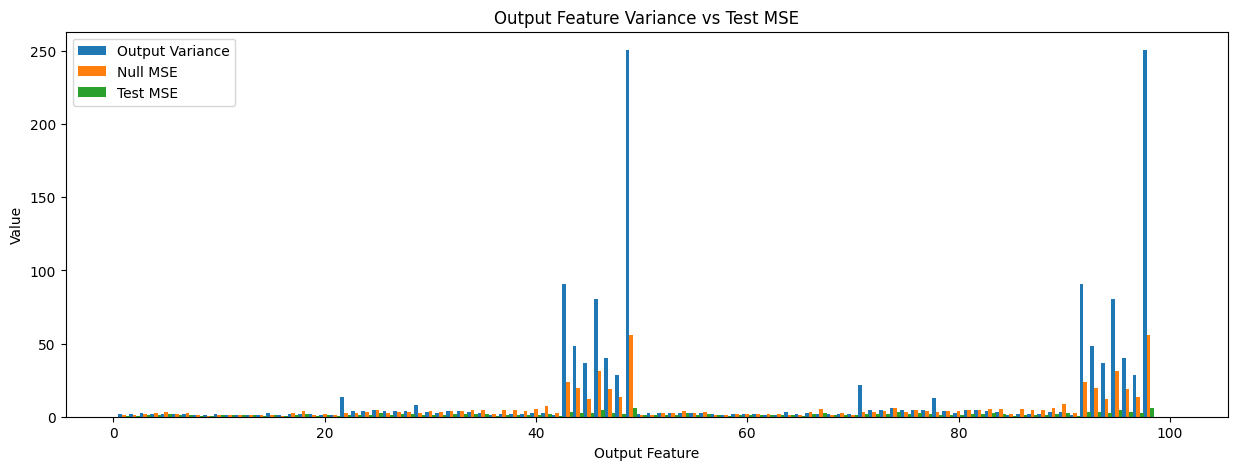

In [31]:
# Step 5: Evaluate the Model on Test Data
model.eval()
with torch.no_grad():
    total_loss = 0
    for X_batch, Y_batch in test_loader:
        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch)
        total_loss += loss.item() * X_batch.size(0)  # sum up batch loss

    avg_loss = total_loss / len(test_dataset)
    print(f"Test Loss: {avg_loss:.4f}")

Y_test_np = Y_test.numpy()
with torch.no_grad():
    Y_pred_np = model(X_test).numpy()

Y_all_np = Y.numpy()
with torch.no_grad():
    Y_pred_all_np = model(X).numpy()

Y_null_all_np = X.numpy()[:, :Y.shape[1]]
Y_null_test_np = X_test.numpy()[:, :Y.shape[1]]

MSE_per_feat = np.mean((Y_test_np - Y_pred_np) ** 2, axis=0)
MSE_per_feat_null = np.mean((Y_test_np - Y_null_test_np) ** 2, axis=0)
feats = np.arange(1, Y.shape[1]+1)
barwid = .35

plt.figure(figsize=(15,5))
plt.bar(feats - barwid, var_per_feat, width=barwid, label='Output Variance')
plt.bar(feats, MSE_per_feat_null, width=barwid, label='Null MSE')
plt.bar(feats + barwid, MSE_per_feat, width=barwid, label='Test MSE')
plt.xlabel('Output Feature')
plt.ylabel('Value')
plt.title('Output Feature Variance vs Test MSE')
plt.legend()
plt.show()

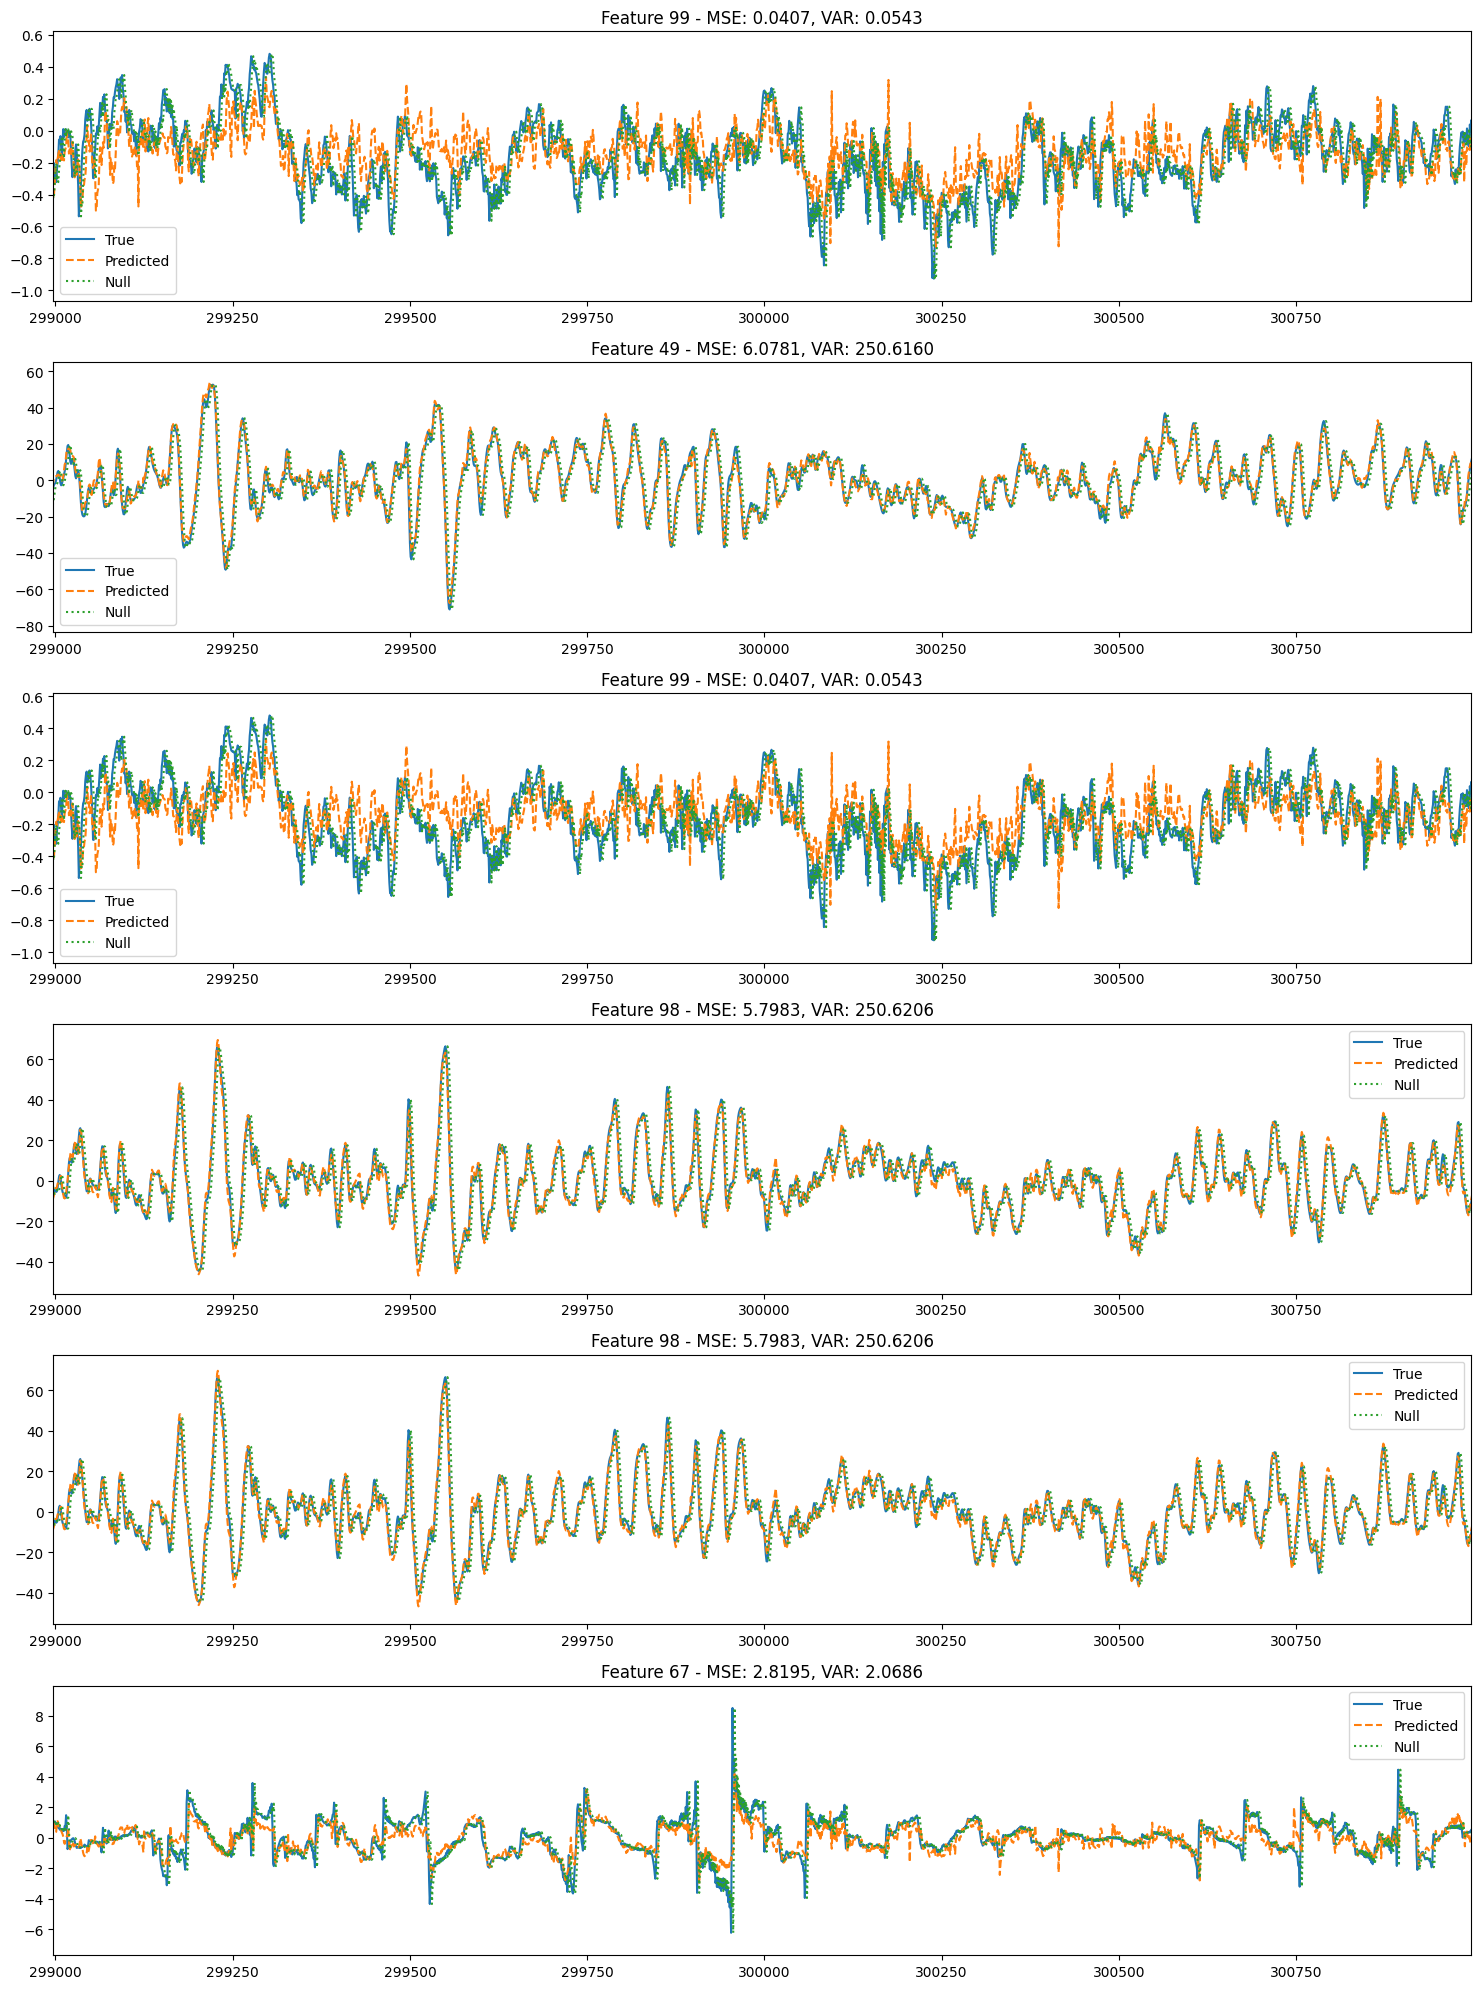

In [37]:
# show several examples 

plotdomain = 1000 * np.array([-1, 1]) + train_N

iMSEmin = np.argmin(MSE_per_feat)
iMSEmax = np.argmax(MSE_per_feat)
iVARmin = np.argmin(var_per_feat)
iVARmax = np.argmax(var_per_feat)
iLRNmin = np.argmin(MSE_per_feat / var_per_feat)
iLRNmax = np.argmax(MSE_per_feat / var_per_feat)
iToPlot = [iMSEmin, iMSEmax, iVARmin, iVARmax, iLRNmin, iLRNmax]

plt.figure(figsize=(15,20))
iPlot = 1
for i in iToPlot:
    plt.subplot(len(iToPlot), 1, iPlot)
    plt.plot(Y_all_np[:, i], label='True')
    plt.plot(Y_pred_all_np[:, i], label='Predicted', linestyle='--')
    plt.plot(Y_null_all_np[:, i], label='Null', linestyle=':')
    plt.xlim(plotdomain)

    # set the y limits to be slightly larger than the min/max of true values in the plotdomain
    y_min = np.min(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_max = np.max(Y_all_np[plotdomain[0]:plotdomain[1], i])
    y_range = y_max - y_min
    plt.ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)
    
    plt.title(f'Feature {i+1} - MSE: {MSE_per_feat[i]:.4f}, VAR: {var_per_feat[i]:.4f}')
    plt.legend()
    iPlot += 1
plt.tight_layout()
plt.show()